# SVB evaluation

This is a preliminary evaluation of hyrbid SVB and comparison with volumetric BASIL. 

A single cortical hemisphere at 32k mesh resolution (HCP functional standard) is used to define anatomy. A sinusoidal variation of CBF is simulated on the cortical surface, whereas all other parameters (WM CBF, GM ATT, WM ATT) are assigned constant default values across the brain. No subcortical GM structures are considered. 

Multi-time ASL data is simulated with increasing levels of noise, and then the following analysis pipelines run: 
1. Hybrid SVB, inferring both CBF and ATT, using spatial priors on both parameters. All GM parameters are estimated on the surface, and WM in the volume.  
2. BASIL volumetric PVEc (via oxford_asl), inferring both CBF and ATT, with a spatial prior on CBF only, followed by volume -> surface projection with Toblerone to transform GM parameters. 


High level summary of results: 
1. Hybrid SVB seems to work (at last)
2. For cortical CBF, there is a clear divergence with BASIL at very high noise levels: BASIL smooths over all detail to return a normal distribution, whereas SVB actually returns increasingly wide distributions to preserve spatial detail (the bright spots are even brighter, and vice-versa)
3. Qualitatively, I think an argument can be made that SVB has some advantages over BASIL at high noise. What metric could we use to show this quantitatively?
4. How much noise is too much? Are the values used below realistic or are they too pathlogically difficult to be realistic?
5. The spatial prior on ATT in SVB isn't as constraining as the normal prior in BASIL. When I use a normal prior in SVB, that seems to perform even worse than the spatial one. Thinking out loud, could we implement the combined spatial and non-spatial prior in SVB? If we are willing to approximate the two priors as statistically independent, then we could just calculate the log(cost) over each prior and sum them together for the objective function?
6. It is difficult to be sure convergence has been reached in SVB under a fixed number of epochs. 


In [1]:
%load_ext autoreload 
%autoreload 2 

import sys 
import numpy as np
import toblerone as tob 
import copy 

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import pyvista as pv 
import pandas as pd 
import nibabel as nib 
from scipy import stats

sys.path.insert(1, '/Users/thomaskirk/Modules/svb_module')
from svb.main import run
from svb.data import HybridModel

import fabber_funcs
import os.path as op
sys.path.insert(1, '/Users/thomaskirk/Modules/svb_models_asl')
from svb_models_asl import AslRestModel 

niiload = lambda p: nib.load(p).get_fdata().flatten()
giiload = lambda p: nib.load(p).darrays[0].data 

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


Load up a pre-computed projector for the single hemisphere. The voxel grid is 3mm isotropic. 

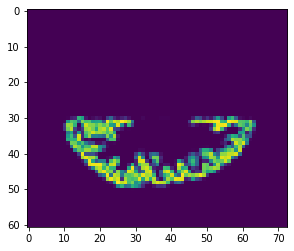

In [2]:
proj = tob.Projector.load('103818_L_hemi.h5')
hemi = proj.hemi_dict['L']
midsurf = hemi.midsurface()
LIS = tob.Surface('103818.L.very_inflated.32k_fs_LR.surf.gii')
spc = proj.spc 
pvs = proj.pvs()
thick_mask = np.linalg.norm(hemi.outSurf.points - hemi.inSurf.points, ord=2, axis=-1)
thick_mask = (thick_mask > 0.5)
nvox = spc.size.prod()
plt.imshow(proj.pvs()[...,spc.size[-1]//2,0])

Simulate sinusoidal CBF map on the cortical *inflated* surface (this gives a smoother and less convoluted map). 

In [3]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

az, el, r = cart2sph(*(LIS.points - LIS.points.mean(0)).T)

def pv_plot(surface, data, **kwargs):
    pl = pv.Plotter(window_size=(600, 400))
    faces = 3 * np.ones((surface.tris.shape[0], 4), dtype=int)
    faces[:,1:] = surface.tris 
    mesh = pv.PolyData(surface.points, faces=faces)
    pl.add_mesh(mesh, scalars=data, **kwargs)
    pl.show(jupyter_backend='pythreejs')

scale = 7
ctx_cbf = 40 + 20 * (np.sin(scale * el)**2 + np.sin(scale/2 * az)**2)
ctx_cbf_vol = proj.surf2vol(ctx_cbf, edge_scale=False)
pv_plot(LIS, ctx_cbf, clim=[40, 80]) 

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

ASL parameters: multi-PLD pCASL 

In [4]:
PLDS = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
BOLUS = 1.8
ATT = [1.3, 1.6]
BASIL_OPTS = { 'tau': BOLUS, 'bat': ATT[0], 'batwm': ATT[1], 'plds': PLDS, }
mask = (proj.pvs()[...,:2] > 0.01).any(-1)
nvox = spc.size.prod()
nverts = midsurf.n_points

Function to simulate data using SVB's *aslrest* model. NB: data is simulated from hybrid space parameters (ie, a set of surface ground truth values, volumetric ground truth), and then projected down into a volumetric representation. This is fundamentally different to simulating data starting from volumetic parameter values. 

In [5]:
def simulate_data(noise, rpt):
    
    data = np.zeros((*spc.size, len(PLDS) * rpt))
    data_model = HybridModel(spc.make_nifti(data), projector=proj)
    asl_model = AslRestModel(data_model,
            plds=PLDS, repeats=rpt, casl=True, inferatt=False)

    with tf.Session() as sess:
        cbf = np.concatenate([
                ctx_cbf[:,None], 20 * np.ones([nvox, 1]) ])

        data = sess.run(asl_model.evaluate(
                [ cbf.astype(np.float32) ], asl_model.tpts()))

    data = proj.hybrid2vol(data, edge_scale=True).reshape(*spc.size, -1)
    data[mask,:] += np.random.normal(0, noise, size=data[mask,:].shape)
    return data


SVB inference / optimisation options used for all runs. 2000 epochs is probably a bit on the long side, 1000 normally is enough. 

In [6]:
options = {
    "mode": "hybrid", 
    "projector": proj, 

    "learning_rate" : 0.25,
    "lr_decay_rate": 0.25, 
    "sample_size" : 4,
    "ss_increase_factor": 8, 
    "epochs" : 2000,

    "batch_size" : len(PLDS),
    "log_stream" : sys.stdout,
    "mask" : mask,
    "plds": PLDS, 
    "casl": True, 
    "prior_type": "M",
    "display_step": 50, 

    "save_model_fit": True, 
    "save_mean": True, 
    "save_input": True, 
}

The experiment: simulate data with increasing noise, and run both SVB and BASIL on them. There are 4 ASL repeats per PLD, which makes (4 * 6) volumes in total. 

In [7]:
NOISE = [1,4,8,12,16,20,24,30]
rpt =  4
df = [] 

# Run with a fixed low level of noise and varying numbers of repeats 
for noise in NOISE: 

    data = simulate_data(noise, rpt)

    # BASIL infer att 
    odir = f"brain_test/basil_noise-{noise}_rpt-{rpt}"
    if not op.exists(op.join(odir, 'output')):
        fabber_funcs.oxasl_cmd(data, mask, odir, { **BASIL_OPTS, 'repeats': rpt }, pvs[...,:2], proj, inferatt=True)

    gm_cbf_v = niiload(op.join(odir, 'output_pvcorr/native/perfusion.nii.gz'))
    gm_cbf = proj.vol2surf(gm_cbf_v.flatten(), edge_scale=False)    
    wm_cbf = niiload(op.join(odir, 'output_pvcorr/native/perfusion_wm.nii.gz'))
    gm_att_v = niiload(op.join(odir, 'output_pvcorr/native/arrival.nii.gz'))
    gm_att = proj.vol2surf(gm_att_v.flatten(), edge_scale=False)    
    wm_att = niiload(op.join(odir, 'output_pvcorr/native/arrival_wm.nii.gz'))
    df.append({ 'method': 'basil', 'noise': noise, 'gm_cbf': gm_cbf, 
                'wm_cbf': wm_cbf, 'gm_att': gm_att, 'wm_att': wm_att })
                
    # SVB infer att 
    odir = f"brain_test/svb_noise-{noise}_rpt-{rpt}"
    if not op.exists(op.join(odir, 'mean_ftiss.nii.gz')):
        run(spc.make_nifti(data), "aslrest",
            odir, repeats=rpt, inferatt=True,
            **options)

    gm_cbf = giiload(op.join(odir, 'mean_ftiss_L_cortex.func.gii'))
    wm_cbf = niiload(op.join(odir, 'mean_ftiss.nii.gz'))
    gm_att = giiload(op.join(odir, 'mean_delttiss_L_cortex.func.gii'))
    wm_att = niiload(op.join(odir, 'mean_delttiss.nii.gz'))
    df.append({ 'method': 'svb', 'noise': noise, 'gm_cbf': gm_cbf, 
                'wm_cbf': wm_cbf, 'gm_att': gm_att, 'wm_att': wm_att })


df = pd.DataFrame(df).set_index(['method', 'noise'])

2022-04-28 12:59:00.804262: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Analysis 1

Surface plots of esimated GM CBF. Note the plot is fully interactive (you can pan and rotate the surfaces), and the colour scale is fixed to the same range for all plots. 

At low levels of noise, BASIL does a remarkably good job of reproducing ground truth, though the intensity of bright / dark spots is definitely clipped a bit. SVB better preserves the full intensity of these details. 

With increasing noise, BASIL tends towards a smooth CBF map and loses further intensity compared to ground truth. By contrast, the SVB map becomes more extreme (the bright spots get brighter, and the dark darker), though in a qualitative sense I believe the spatial detail of ground truth is better preserved. 

In [8]:
pl = pv.Plotter(shape=(len(NOISE), 3), window_size=(800,2500))
faces = 3 * np.ones((LIS.tris.shape[0], 4), dtype=int)
faces[:,1:] = LIS.tris 
mesh = pv.PolyData(LIS.points, faces=faces)

for idx,noise in enumerate(NOISE): 

    basil, svb = df.xs(noise, level='noise').gm_cbf
    pl.subplot(idx,0)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=basil, clim=[40,80])
    pl.add_title(f'BASIL noise std. {noise}')

    pl.subplot(idx,1)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=ctx_cbf, clim=[40,80])
    pl.add_title(f'Truth')

    pl.subplot(idx,2)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=svb, clim=[40,80])
    pl.add_title(f'SVB noise std. {noise}')

pl.show(jupyter_backend='panel')

BokehModel(combine_events=True, render_bundle={'docs_json': {'84075e56-c58e-4858-b4a5-9e49f3d5fc7c': {'defs': …

## Analysis 2

Plot 1D distributions of cortical CBF. This helps illustrates the presence of bias and/or excessive smoothing as noise increases. 

Neither method shows any bias at all noise levels, but SVB returns a wider and wider distribution (the extremes are further apart), whereas BASIL returns an increasingly normal distribution at high noise levels. 

/var/folders/lv/mwp4mfb163n5t2wqyhm281vm0000gn/T/ipykernel_22554/720023859.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


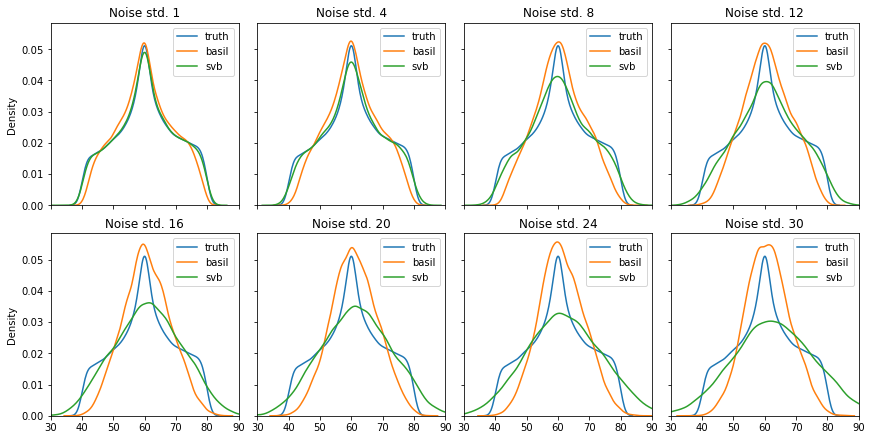

In [9]:
fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(12,6), sharex=True, sharey=True)

for ax, noise in zip(axes.flat, NOISE): 
    sns.kdeplot(x=ctx_cbf[thick_mask], label='truth', ax=ax, color=cmap[0])
    sns.kdeplot(x=df.loc['basil', noise]['gm_cbf'][thick_mask], label='basil', ax=ax, color=cmap[1])
    sns.kdeplot(x=df.loc['svb', noise]['gm_cbf'][thick_mask], label='svb', ax=ax, color=cmap[2])

    ax.set_title(f'Noise std. {noise}')
    ax.legend()
    ax.set_xlim(30, 90)

fig.show()

## Analysis 3

We can evaluate the accuracy of each methods estimates using sum of squared differences wrt. ground truth. Interestingly, this analysis shows SVB performs worse than BASIL for high noise levels (presumably because it returns more extreme CBF values than BASIL, which more and more resembles a normal distribution at high noise). 

Given the surface plots above suggest SVB does better preserve spatial detail at high noise, we can run an alternative analysis using Z-scores. The idea behind this is that spatial detail arises due to contrast between bright and dark spots; if SVB is able to maintain contrast in a relative sense at high noise, then the corresponding Z-scores should show this. Conversely, as BASIL's results tend towards a normal distribution, the associated Z-scores should suffer. 

On both of these metrics, SVB performs worse than BASIL on anything but the lowest noise values. And yet, from the surface plots, we can see that it is still conveying spatial detail at these noise levels. So, we need to think of a metric that conveys this - do you have any ideas?

In [10]:
cbf_ssd = df.gm_cbf.apply(lambda c: ((c - ctx_cbf)[thick_mask] ** 2).sum())
df['cbf_ssd'] = cbf_ssd

cortex_zscore = df.gm_cbf.apply(stats.zscore)
true_zscore = stats.zscore(ctx_cbf)
zscore_ssd = cortex_zscore.apply(lambda z: ((z - true_zscore)[thick_mask] ** 2).sum())
df['zscore_ssd'] = zscore_ssd

Text(0.5, 1.0, 'SSD in Z-score CBF')

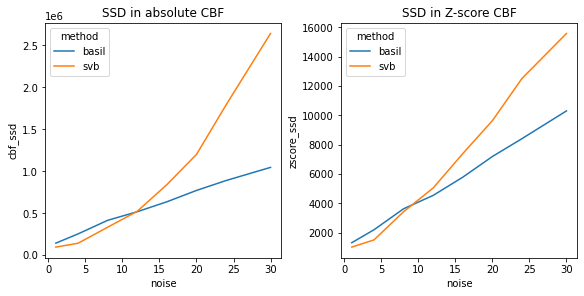

In [11]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, sharex=True, figsize=(8,4))

ax = axes[0]
sns.lineplot(data=df, x='noise', y='cbf_ssd', hue="method", ax=ax)
ax.set_title('SSD in absolute CBF')

ax = axes[1]
sns.lineplot(data=df, x='noise', y='zscore_ssd', hue="method", ax=ax)
ax.set_title('SSD in Z-score CBF')


## Analysis 4

What about all the other parameters (GM ATT, WM CBF, WM ATT)? 

Because these are all fixed as constant values in the simulation, we investigate these by plotting distributions across all noise levels and comparing to the ground truth distribution mean (a delta function, ie, all the distribution is concentrated at one value). 

WM CBF: there seems to be a bias for BASIL at all noise levels. This could be due to a difference in the SVB aslrest model compared to BASIL's. For example, when I've previously seen this problem, it was due to a differing fcalibwm value, though this time round I don't think it is that. Martin, I'm hoping you might have a clever idea for what to check to fix this. For SVB, the presence of extremely high noise eventually leads to bias as well, though it could also be the case that the optimisation simply hasn't converged yet (hard to know). FWIW, I have often observed across both methods that extremely high noise can lead to positive bias in WM CBF; this may simply be a property of the aslrest model (ie, the noise combines with non-linearity to give an alias solution of increased CBF and ATT). 

ATT values: in general, it seems that SVB's spatial prior on ATT isn't as tight as BASIL's non-spatial, as we consistently see a similar-or-wider distribution for SVB than BASIL. I have previously tried using a non-spatial prior on ATT in SVB but this seems to perform even worse than the spatial prior (an even wider distribution). 

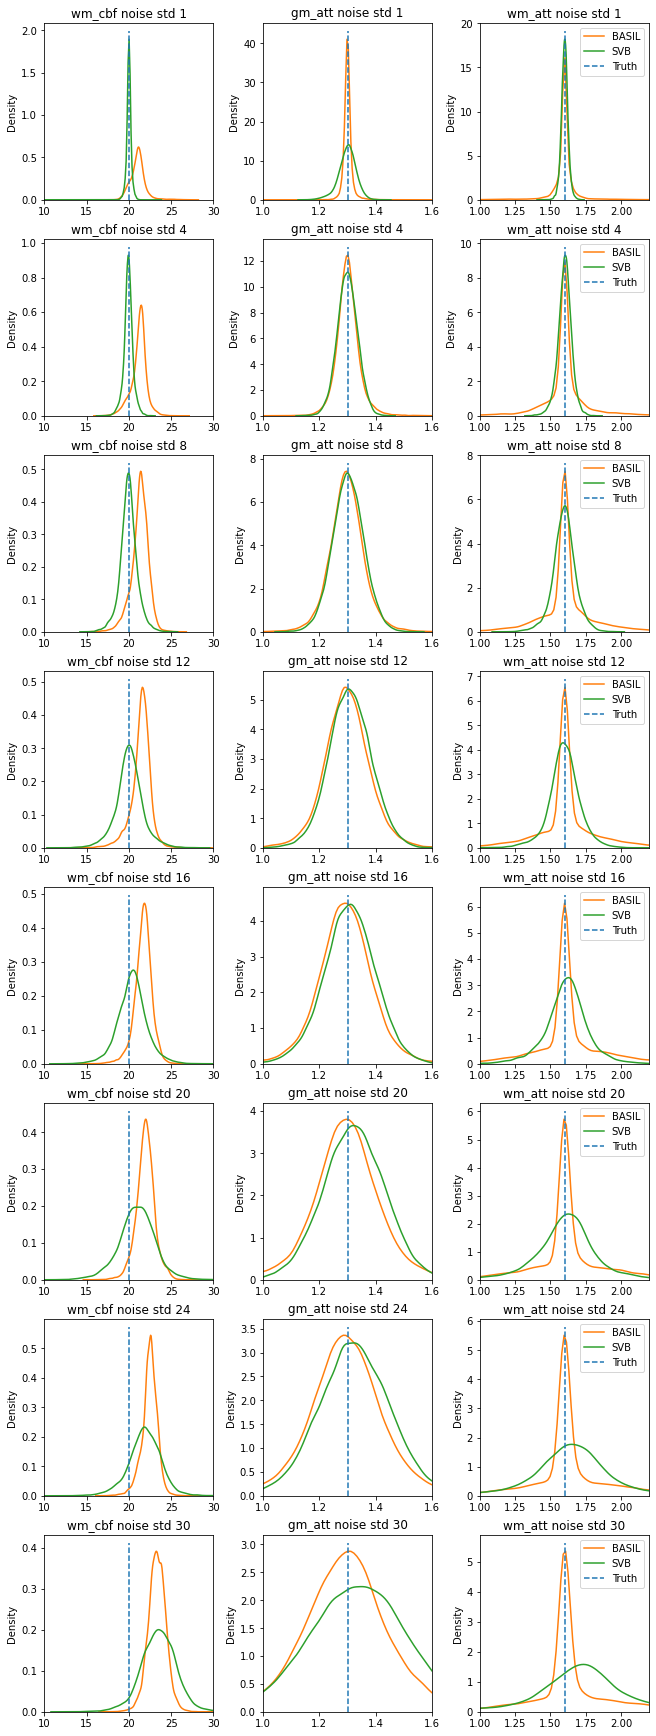

In [12]:
fig, axes_all = plt.subplots(len(NOISE), 3, constrained_layout=True, figsize=(9,3*len(NOISE)))

for idx,noise in enumerate(NOISE): 

    keys = ['wm_cbf', 'gm_att', 'wm_att']
    truths = [ 20, 1.3, 1.6 ]
    lims = [[10,30], [1,1.6], [1,2.2]]
    for ax, key, truth, lim in zip(axes_all[idx,:], keys, truths, lims): 
        ax.set_title(f'{key} noise std {noise}')
        m = mask.flatten() if ('wm' in key) else thick_mask
        sns.kdeplot(df.loc['basil',noise][key][m], ax=ax, label='BASIL', color=cmap[1])
        sns.kdeplot(df.loc['svb',noise][key][m], ax=ax, label='SVB', color=cmap[2])
        ax.plot([truth, truth], [0, ax.get_ylim()[1]], label='Truth', color=cmap[0], linestyle='--')
        ax.set_xlim(*lim)

    ax.legend()